1. Взять ожидания аналитиков, что будет в будущем и на этом основании прогнозировать <br>
2. Использовать Дамми если есть шок, которые не связан с экзогенными переменными <br>
3. Данные по компании (производственные мощности) - прогнозирование <br>
4. Что-то не так с прогнозами? Или это проблема в том, что данные плохо прогнозируются этими моделями? Смотрет предикшн в конце


In [1]:
import time

import pandas as pd
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sktime.utils.plotting import plot_series, plot_correlations

from statsmodels.tsa.stattools import adfuller, kpss

# Models and decompositions
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from sktime.forecasting.model_selection import ExpandingWindowSplitter, ForecastingGridSearchCV
from sktime.forecasting.ets import AutoETS

#Metrics
from sklearn.metrics import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

# warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
warnings.simplefilter('ignore')

In [2]:
fx_rates = pd.read_csv('fx_rates.csv')
fx_rates['Date'] = pd.to_datetime(fx_rates['Date'].astype(str).str[0:10])
#fx_rates['Date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in fx_rates['Date']]
fx_rates = fx_rates.set_index('Date')

df = pd.read_csv('nickel_industries_ts_data.csv')
df['Date'] = pd.to_datetime(df['Date'].astype(str).str[0:10])
#df['Date'] = [pd.Timestamp(t, tz='Australia/Sydney') for t in df['Date']]
df = df.set_index('Date')

df.drop(columns='Stock Splits', inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54 entries, 2018-09-30 to 2023-02-28
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Close                         54 non-null     float64
 1   Volume                        54 non-null     int64  
 2   Dividends                     54 non-null     float64
 3   Ni_price                      54 non-null     float64
 4   aus_int_rate                  54 non-null     float64
 5   Base_metal_products_vol       52 non-null     float64
 6   Nickel_ore_vol                52 non-null     object 
 7   Base_metal_products_val_mil$  53 non-null     float64
 8   Nickel_ore_val_mil$           53 non-null     object 
 9   Export_to_China_mil$          53 non-null     float64
dtypes: float64(7), int64(1), object(2)
memory usage: 4.6+ KB


# SPLITS

In [4]:
endog = df['Close']
exog = df[['Ni_price', 'aus_int_rate', 'Base_metal_products_vol']]

# prices without any transformations - could be not only prices but returns, log-return etc
endog_train_p = endog.loc[:'2022-08-31']
endog_test_p = endog.loc['2022-09-30':]

# variable used in model - could be not only prices but returns, log-return etc
endog_all = endog
endog_train = endog.div(endog.shift()).dropna().loc[:'2022-08-31']
endog_train_ind = endog_train.reindex(pd.date_range(start=endog_train.index[0], end=endog_train.index[-1], freq='M'))
endog_test = endog.div(endog.shift()).dropna().loc['2022-09-30':]

exog_train = exog.loc[:'2022-08-31']
exog_test = exog.loc['2022-09-30':]

final_performance_cols = ['Is_y_transformed?', 'Model', 'Train_MAPE', 'Test_MAPE']
model_performance = pd.DataFrame(columns=final_performance_cols)

horizon = list(range(1, 7))

# Grapical analysis

In [5]:
# Add KPSS test

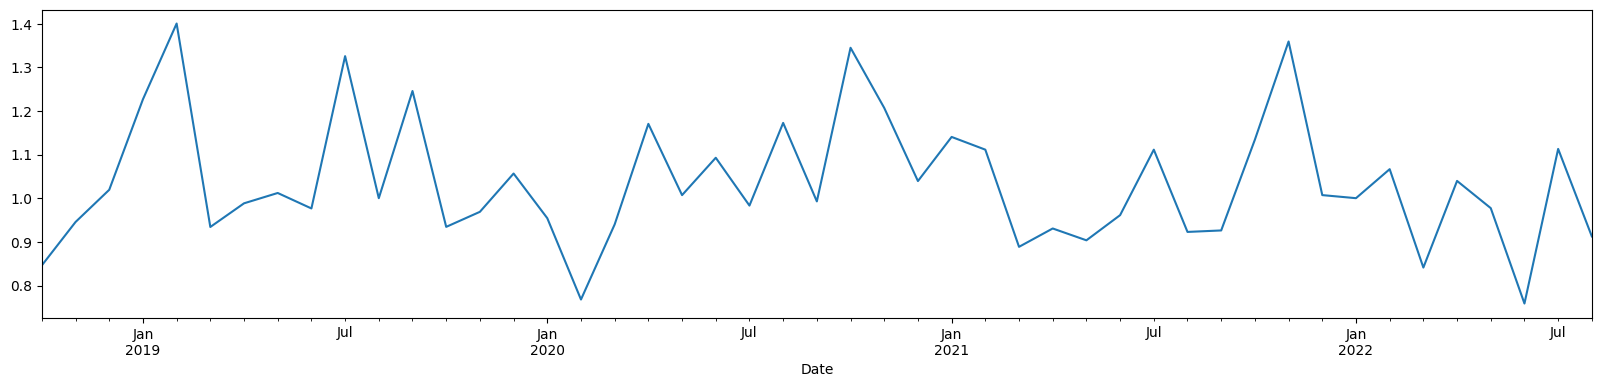

In [6]:
endog_train.plot(figsize=(20,4));

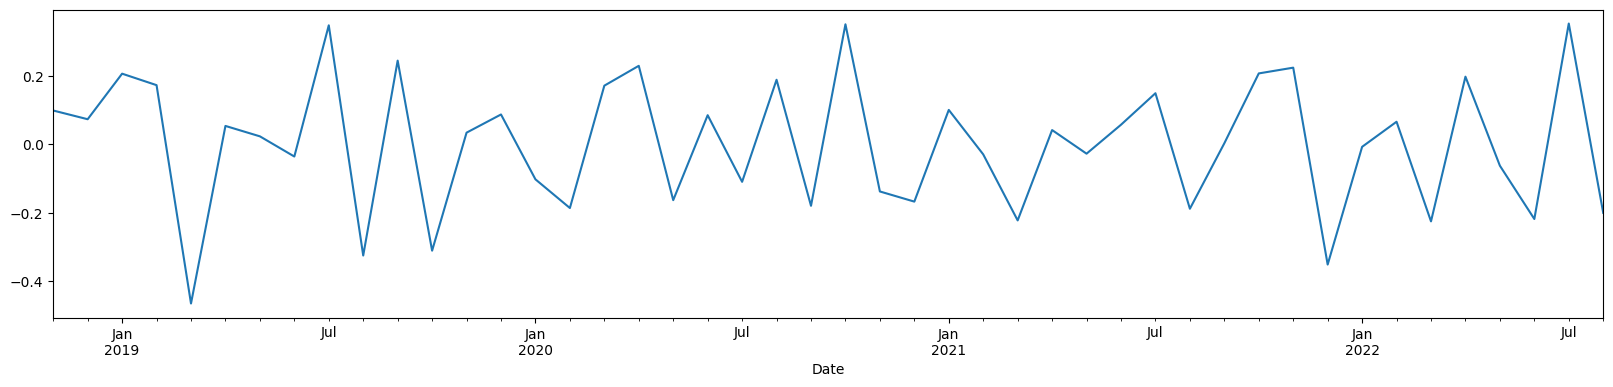

In [7]:
endog_train.diff().dropna().plot(figsize=(20,4));

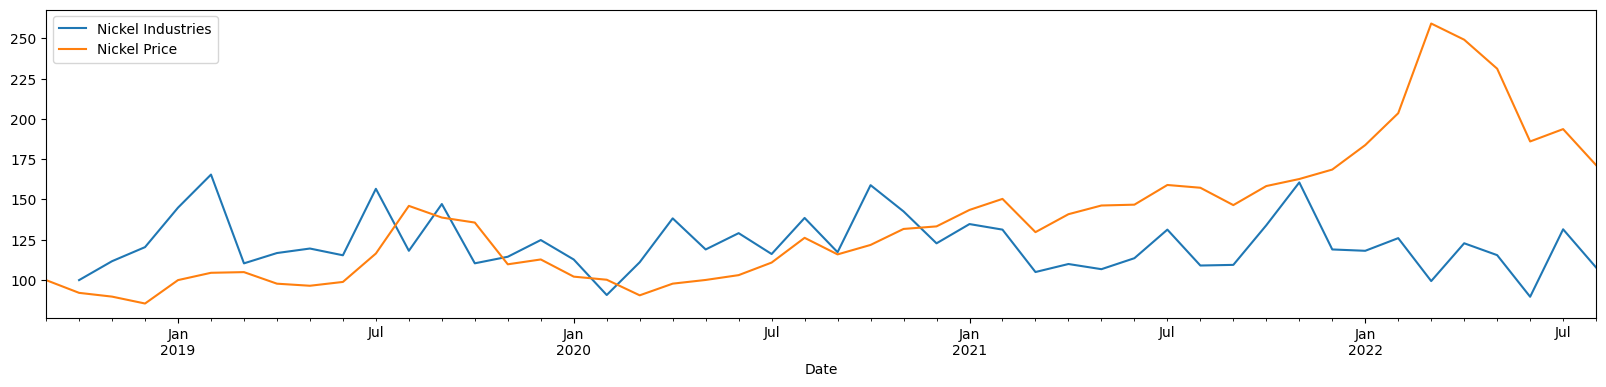

In [8]:
# Normalizing and comparison
# Both series start from 100
ni_price = pd.DataFrame(exog['Ni_price'].loc[:'2022-08-31'])
normalized_price = endog_train.div(endog_train.iloc[0]).mul(100)
normalized_ni = ni_price.Ni_price.div(ni_price.Ni_price.iloc[0]).mul(100)
normalized_price.plot(figsize=(20,4))
normalized_ni.plot(figsize=(20,4))
plt.legend(['Nickel Industries','Nickel Price'])
plt.show()

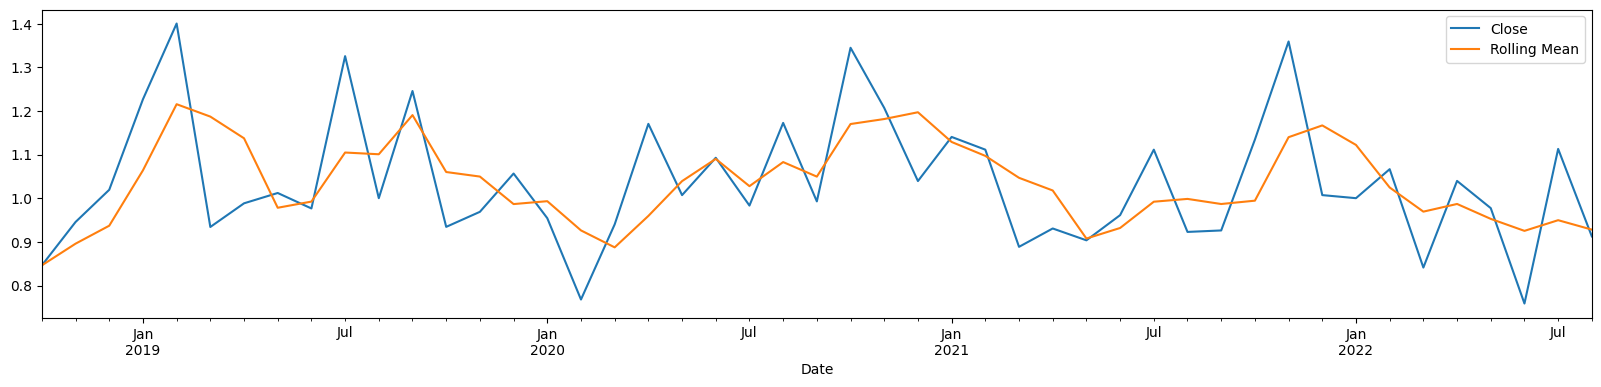

In [9]:
# Rolling window functions
rolling_price = endog_train.rolling('90D').mean()

endog_train.plot()
rolling_price.plot(figsize=(20,4))
plt.legend(['Close','Rolling Mean'])
# Plotting a rolling mean of 90 day window with original Close attribute of Nickel Industries stocks
plt.show()

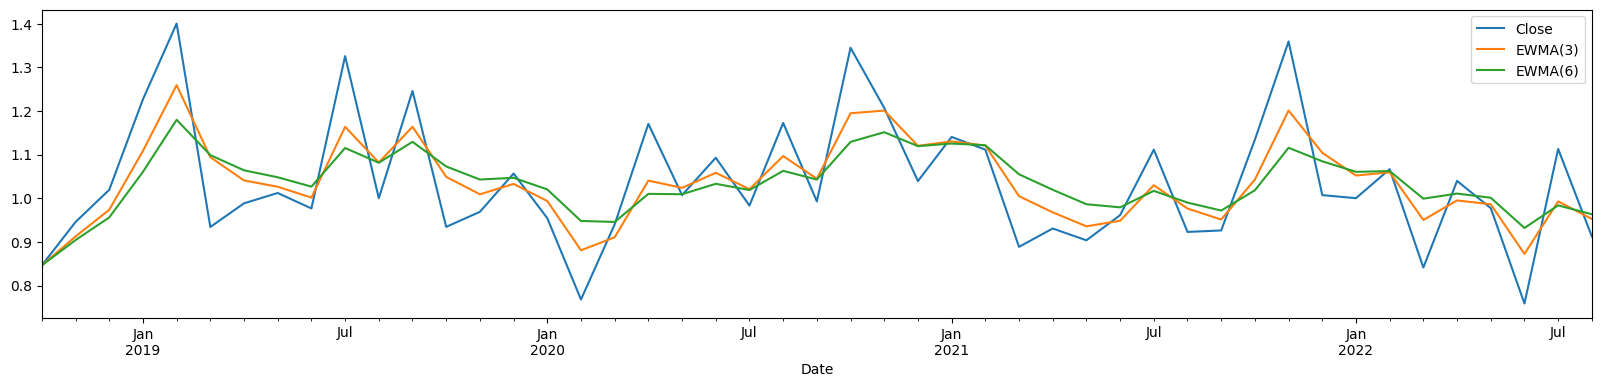

In [10]:
column = 'Close'
ewma = pd.DataFrame(endog_train)
for span in [3, 6]:
    ewma['EWMA(' + str(span) + ')'] = ewma[column].ewm(span=span).mean()
ewma.plot(figsize=(20, 4))
plt.show()

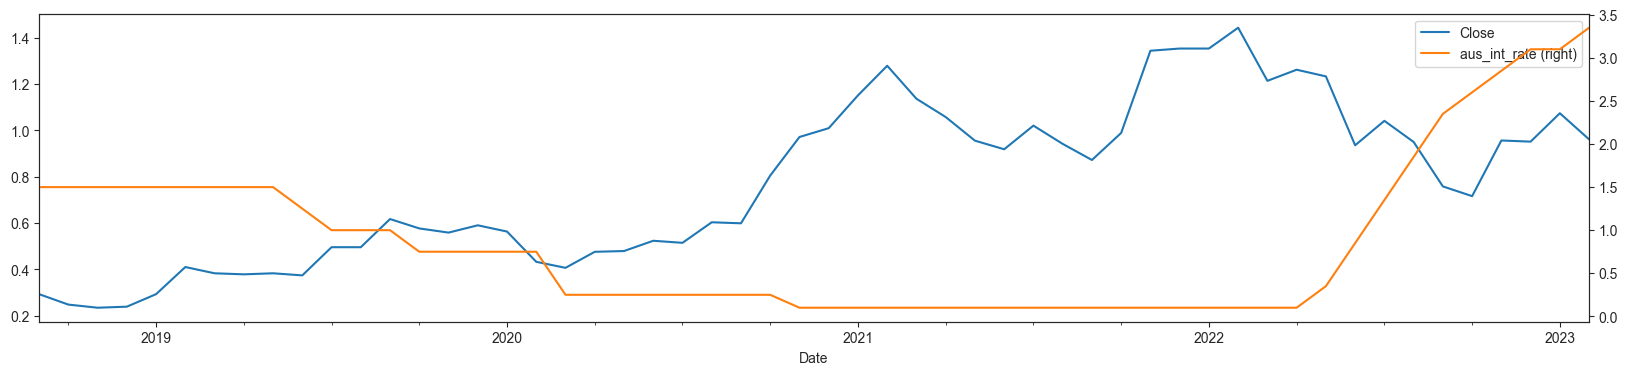

In [11]:
with sns.axes_style('white'):
    sns.set_style('ticks')
    df[['Close', 'aus_int_rate']].plot(figsize=(20, 4), secondary_y=['aus_int_rate'])
    plt.show()

# Autocorrelation funtions (ACF, PACF)

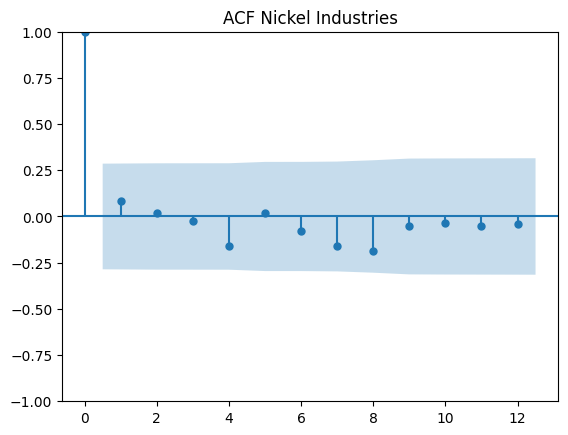

In [12]:
# Autocorrelation of stock price of Nickel Industries
plot_acf(endog_train, lags=12, title="ACF Nickel Industries")
plt.show()

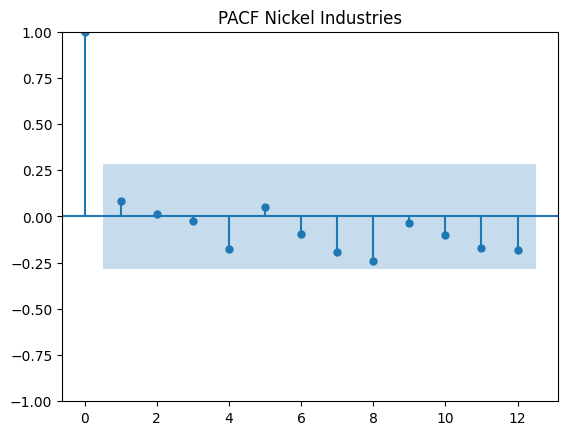

In [13]:
# Partial autocorrelation of stock price of Nickel Industries
plot_pacf(endog_train, lags=12, title="PACF Nickel Industries")
plt.show()

## Augmented Dickey-Fuller test (ADF)

H0: β = 0 (This is a random walk) <br>
H1: β < 0 (This is not a random walk)

In [14]:
# Augmented Dickey-Fuller test on volume/price
adf_price = adfuller(endog_train)
print("p-value of price: {}".format(float(adf_price[1].round(4))))
adf_vol = adfuller(df["Volume"])
print("p-value of volume: {}".format(float(adf_vol[1].round(4))))

p-value of price: 0.0
p-value of volume: 0.0001


In [15]:
# Augmented Dickey-Fuller test on volume/price
# adf_rel_change = adfuller(only_price["rel_change"].dropna())
# print("p-value of relative change: {}".format(float(adf_rel_change[1].round(4))))

# adf_return = adfuller(only_price["return"].dropna())
# print("p-value for return: {}".format(float(adf_return[1].round(4))))

# adf_diff = adfuller(only_price["diff"].dropna())
# print("p-value for diff: {}".format(float(adf_diff[1].round(4))))

# STL Decomposition

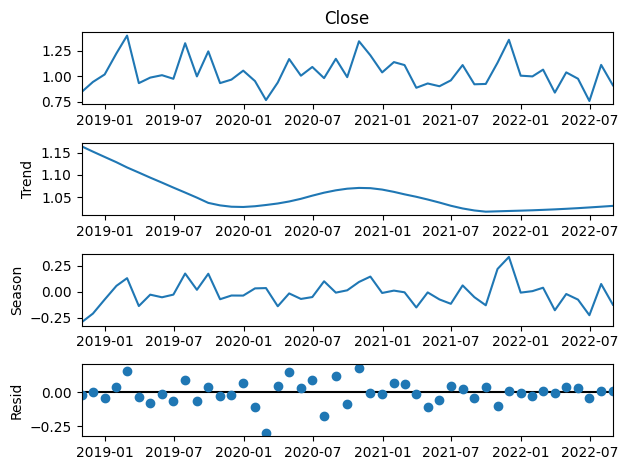

In [16]:
stl_decomp_mod = STL(endog_train)
stl_decomp_res = stl_decomp_mod.fit()
figure_1 = stl_decomp_res.plot()
plt.show()

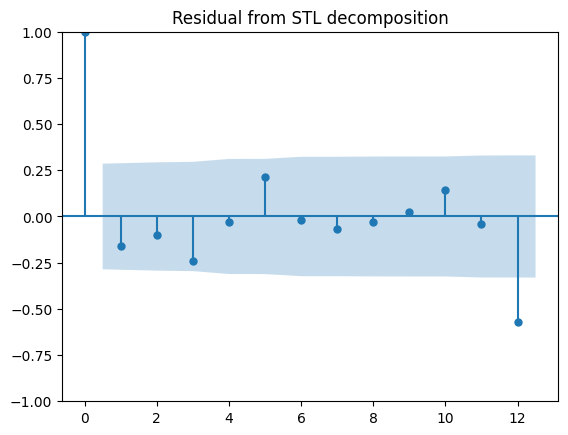

In [17]:
# Check whether residual have zero mean and have no autocorrelation
plot_acf(stl_decomp_res.resid, lags=12, title="Residual from STL decomposition")
plt.show()

# ETS

## ETS auto

In [18]:
ets_model = AutoETS(sp=4) # quarterly seasonality assumed? 
grid = {'error': ['add', 'mul'], 'trend': ['add', 'mul', None], 'seasonal': ['add', 'mul', None]}

cv_params = ExpandingWindowSplitter(initial_window=len(endog_train)-len(horizon), fh=horizon, step_length=1)

ets_cv = ForecastingGridSearchCV(forecaster=ets_model, cv=cv_params, 
                                 param_grid=grid, error_score='raise')

In [19]:
ETS_auto_res = ets_cv.fit(endog_train_ind)
#ETS_auto_pred = ETS_auto_res.predict(fh=horizon)
ETS_auto_res.best_params_

{'error': 'mul', 'seasonal': 'add', 'trend': 'add'}

In [20]:
ETS_auto_model = ETSModel(endog_train, 
                          error=ETS_auto_res.best_params_['error'], 
                          trend=ETS_auto_res.best_params_['trend'], 
                          seasonal=ETS_auto_res.best_params_['seasonal'], 
                          seasonal_periods=4, 
                          freq='M')
ETS_best_res = ETS_auto_model.fit()
ETS_best_pred = ETS_best_res.predict()

#mean_absolute_percentage_error(endog_test, ETS_best_res.forecast(len(horizon))).round(5)
mean_absolute_percentage_error(endog_train, ETS_best_pred).round(5)

0.11272

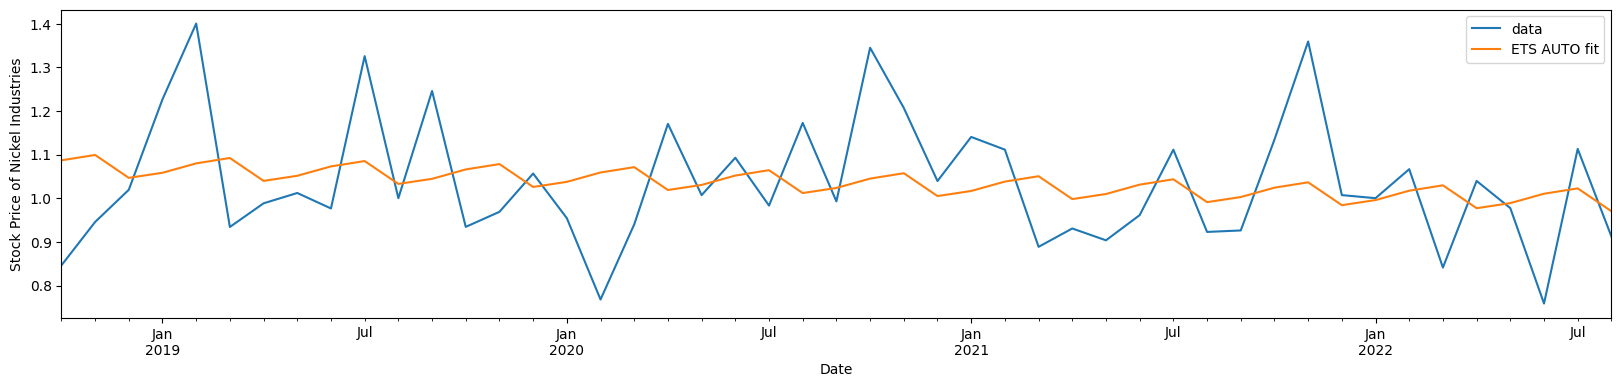

In [21]:
endog_train.plot(label="data", figsize=(20, 4))
ETS_best_res.fittedvalues.plot(label="ETS AUTO fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

## ETS (AAN)

In [22]:
ETS_AAN_model = ETSModel(endog_train, 
                          error = 'add', 
                          trend = 'add', 
                          seasonal = None, 
                          seasonal_periods=4, 
                          freq='M')
ETS_AAN_res = ETS_AAN_model.fit()
ETS_AAN_pred = ETS_AAN_res.predict()

#mean_absolute_percentage_error(endog_test, ETS_best_res.forecast(len(horizon))).round(5)
mean_absolute_percentage_error(endog_train, ETS_AAN_pred).round(5)

0.11173

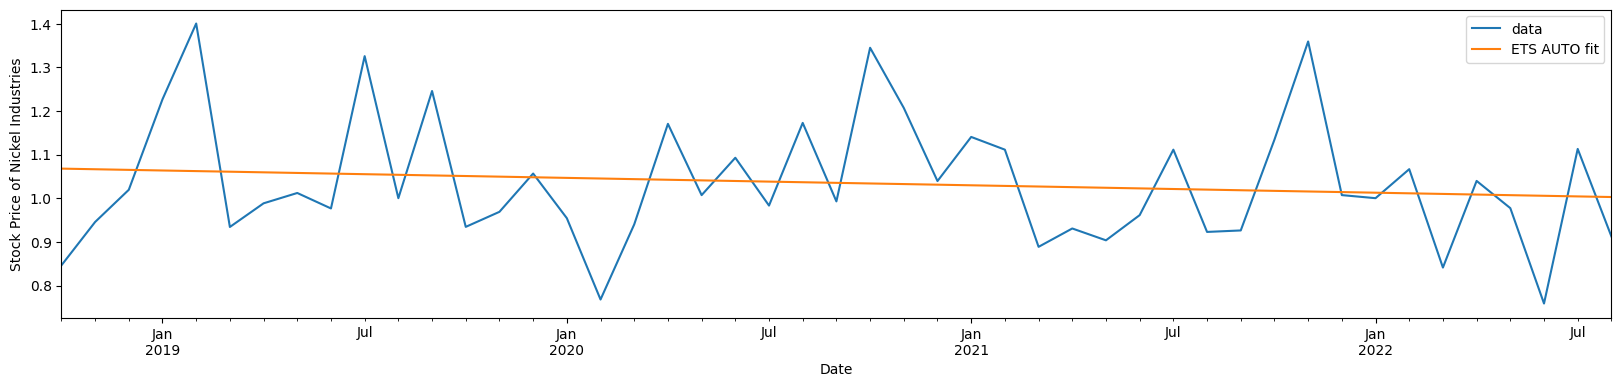

In [23]:
endog_train.plot(label="data", figsize=(20, 4))
ETS_AAN_res.fittedvalues.plot(label="ETS AUTO fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

# ETS (MAN)

In [24]:
ETS_MAN_model = ETSModel(endog_train, 
                          error = 'mul', 
                          trend = 'add', 
                          seasonal = None, 
                          seasonal_periods=4, 
                          freq='M')
ETS_MAN_res = ETS_MAN_model.fit()
ETS_MAN_pred = ETS_MAN_res.predict()

#mean_absolute_percentage_error(endog_test, ETS_best_res.forecast(len(horizon))).round(5)
mean_absolute_percentage_error(endog_train, ETS_MAN_pred).round(5)

0.11201

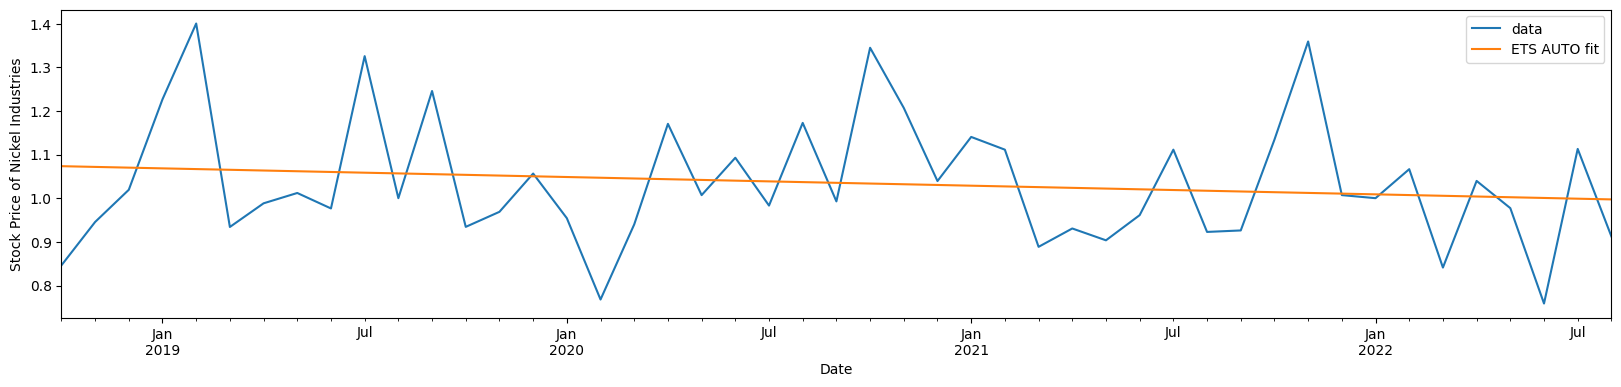

In [25]:
endog_train.plot(label="data", figsize=(20, 4))
ETS_MAN_res.fittedvalues.plot(label="ETS AUTO fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

# ARIMA

## ARIMA GridSearch

In [26]:
# Tuning hyperparameters
p_params = range(0, 5, 1)
q_params = range(0, 5, 1)
d_params = 0

In [27]:

def ARIMAGridSearch(y_train, p_params, q_params, d_params):
    # Create dictionary to store MAPEs
    mape_grid = dict()
    # Outer loop: Iterate through possible values for `p`
    for p in p_params:
        # Create key-value pair in dict. Key is `p`, value is empty list.
        mape_grid[p] = list()
        # Inner loop: Iterate through possible values for `q`
        for q in q_params:
            # Combination of hyperparameters for model
            order = (p, d_params, q)
            # Note start time
            start_time = time.time()
            # Train model
            model = ARIMA(y_train, order=order).fit()
            # Generate in-sample (training) predictions
            y_pred = model.predict()
            # Calculate training MAE
            mape = mean_absolute_percentage_error(y_train, y_pred)
            # Calculate model training time
            elapsed_time = round(time.time() - start_time, 2)
            print(f"Trained ARIMA {order} in {elapsed_time} seconds. MAPE is {mape.round(5)}")
            # Append MAE to list in dictionary
            mape_grid[p].append(mape)
    
    cols = ['AR' + str(x) for x in p_params]
    index = ['MA' + str(x) for x in q_params]
    grid_arima = pd.DataFrame.from_dict(mape_grid)
    grid_arima.columns = cols
    grid_arima.index = index
    
    return grid_arima


In [28]:
grid_arima = ARIMAGridSearch(endog_train, p_params, q_params, d_params)

Trained ARIMA (0, 0, 0) in 0.05 seconds. MAPE is 0.11014
Trained ARIMA (0, 0, 1) in 0.04 seconds. MAPE is 0.11123
Trained ARIMA (0, 0, 2) in 0.09 seconds. MAPE is 0.11144
Trained ARIMA (0, 0, 3) in 0.17 seconds. MAPE is 0.11134
Trained ARIMA (0, 0, 4) in 0.31 seconds. MAPE is 0.10842
Trained ARIMA (1, 0, 0) in 0.03 seconds. MAPE is 0.11131
Trained ARIMA (1, 0, 1) in 0.05 seconds. MAPE is 0.11133
Trained ARIMA (1, 0, 2) in 0.24 seconds. MAPE is 0.11143
Trained ARIMA (1, 0, 3) in 0.26 seconds. MAPE is 0.10532
Trained ARIMA (1, 0, 4) in 0.25 seconds. MAPE is 0.10518
Trained ARIMA (2, 0, 0) in 0.05 seconds. MAPE is 0.11135
Trained ARIMA (2, 0, 1) in 0.19 seconds. MAPE is 0.11136
Trained ARIMA (2, 0, 2) in 0.3 seconds. MAPE is 0.0991
Trained ARIMA (2, 0, 3) in 0.39 seconds. MAPE is 0.11107
Trained ARIMA (2, 0, 4) in 0.44 seconds. MAPE is 0.09998
Trained ARIMA (3, 0, 0) in 0.14 seconds. MAPE is 0.11171
Trained ARIMA (3, 0, 1) in 0.29 seconds. MAPE is 0.10394
Trained ARIMA (3, 0, 2) in 0.42 s

## Best ARIMA via GridSearch - order (4, 0, 4)

In [29]:
model_ARIMA_best = ARIMA(order=(4, 0, 4), endog=endog_train, freq='M')
model_ARIMA_best_res = model_ARIMA_best.fit()
model_ARIMA_best_pred = model_ARIMA_best_res.predict()
mean_absolute_percentage_error(endog_train, model_ARIMA_best_pred)

0.0956413326183367

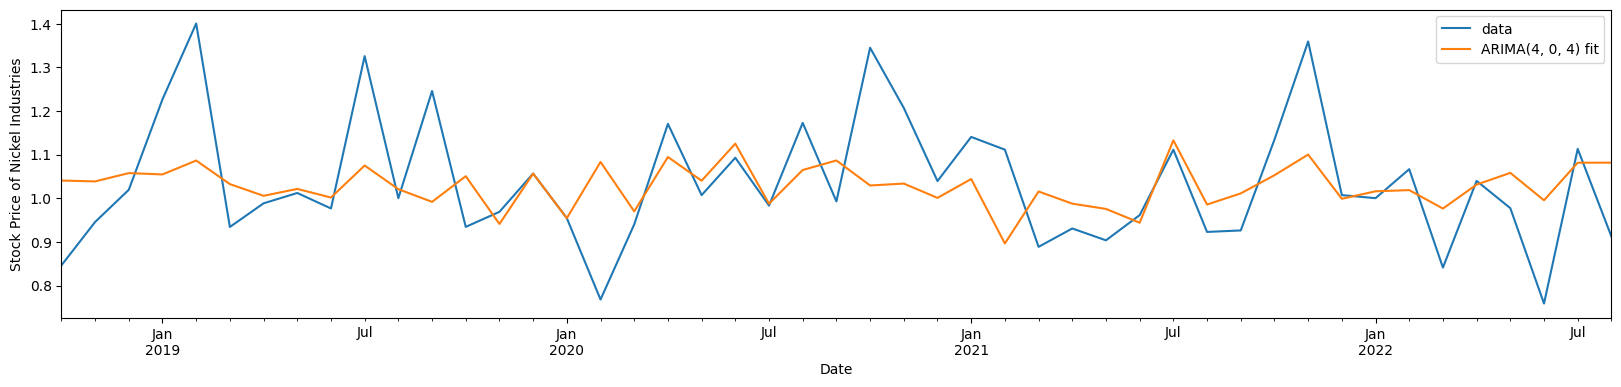

In [30]:
endog_train.plot(label="data", figsize=(20, 4))
model_ARIMA_best_pred.plot(label="ARIMA(4, 0, 4) fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

## ARIMA (12, 1, 2)

In [31]:
model_ARIMA_12_1_2 = ARIMA(order=(12, 1, 2), endog=endog_train, freq='M')
model_ARIMA_12_1_2_res = model_ARIMA_12_1_2.fit()
model_ARIMA_12_1_2_pred = model_ARIMA_12_1_2_res.predict()
mean_absolute_percentage_error(endog_train, model_ARIMA_12_1_2_pred)

0.12865276468819156

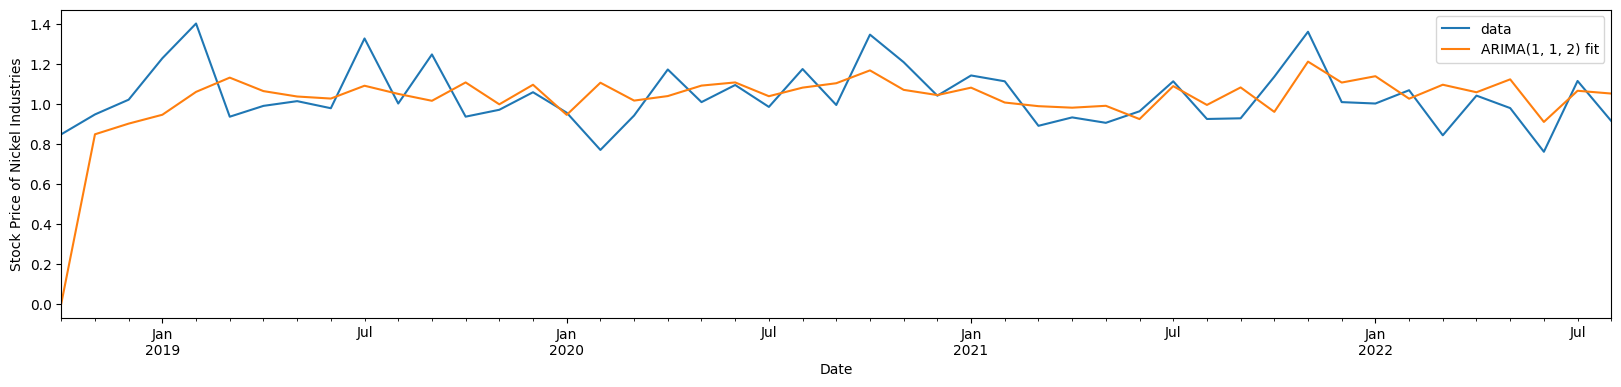

In [32]:
endog_train.plot(label="data", figsize=(20, 4))
model_ARIMA_12_1_2_pred.plot(label="ARIMA(1, 1, 2) fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

## ARIMA (6, 1, 1)

In [33]:
model_ARIMA_6_1_1 = ARIMA(order=(6, 1, 1), endog=endog_train, freq='M')
model_ARIMA_6_1_1_res = model_ARIMA_6_1_1.fit()
model_ARIMA_6_1_1_pred = model_ARIMA_6_1_1_res.predict()
mean_absolute_percentage_error(endog_train, model_ARIMA_6_1_1_pred)

0.13441012593034224

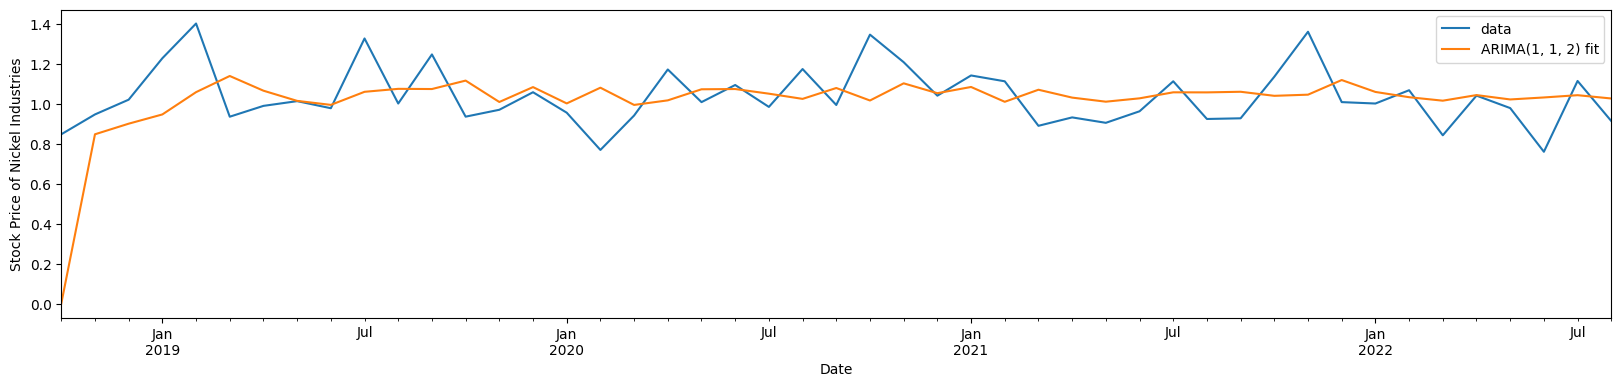

In [34]:
endog_train.plot(label="data", figsize=(20, 4))
model_ARIMA_6_1_1_pred.plot(label="ARIMA(1, 1, 2) fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

# Model comparison

We choose all best models from each step and try them on test set.

In [35]:
# ETS
mean_absolute_percentage_error(endog_test, ETS_best_res.forecast(len(horizon))).round(5)

0.13561

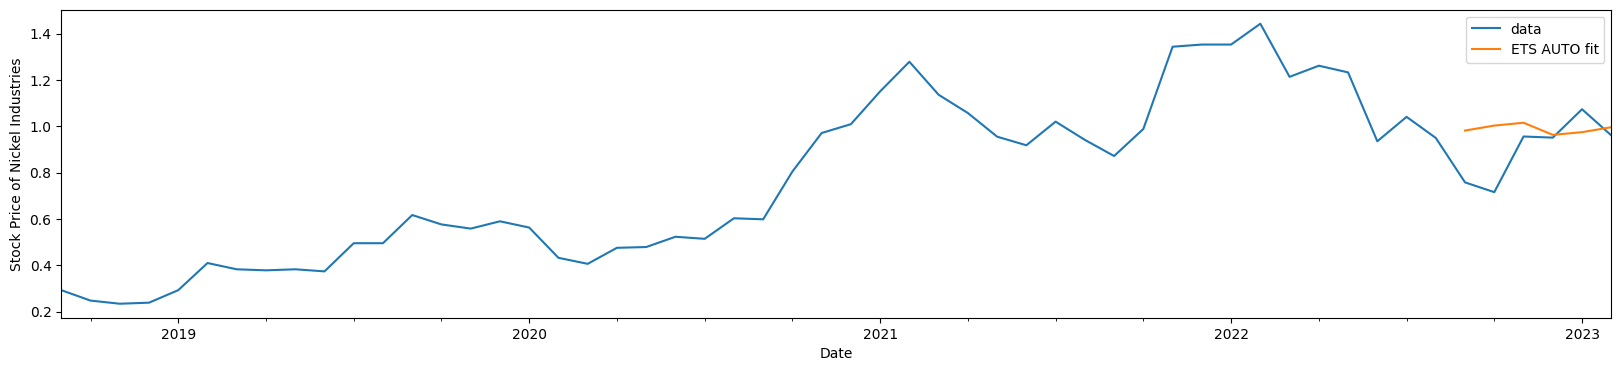

In [36]:
endog_all.plot(label="data", figsize=(20, 4))
ETS_best_res.forecast(len(horizon)).plot(label="ETS AUTO fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();

In [37]:
mean_absolute_percentage_error(endog_test, model_ARIMA_best_res.predict(start=endog_test.index[0], end=endog_test.index[-1])).round(5)

0.19134

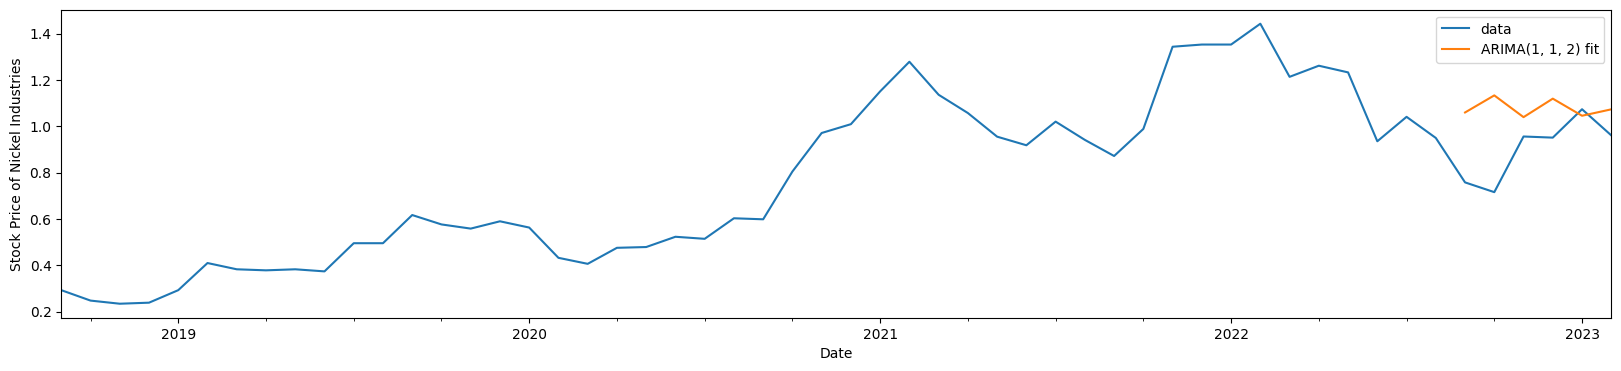

In [38]:
endog_all.plot(label="data", figsize=(20, 4))
model_ARIMA_best_pred = model_ARIMA_best_res.predict(start=endog_test.index[0], end=endog_test.index[-1])
model_ARIMA_best_pred.plot(label="ARIMA(1, 1, 2) fit")
plt.ylabel("Stock Price of Nickel Industries")
plt.legend();